
# Chapter 4: OSTEP 벡터 인덱스 구축 (FAISS HNSW)

OSTEP 임베딩 벡터로 HNSW 인덱스를 생성/저장하고 검색 품질을 검증합니다.

## 📚 학습 목표
- HNSW 인덱스 구성요소와 핵심 파라미터(M/efConstruction/efSearch) 이해
- 인덱스 저장/로드 파이프라인 구현 및 활용법 학습
- 인덱스 품질 검증을 위한 간단한 검색/점수화 루틴 작성

## 📋 실습 구성
- 1️⃣ 환경 설정: 패키지 설치, 경로/상수 정의
- 2️⃣ 데이터 로드: 임베딩/청크 로드 및 일치성 검증
- 3️⃣ Ground Truth: 브루트포스로 참값 생성/저장
- 4️⃣ 인덱스 구축/저장: HNSW 생성, 파라미터 적용, 파일 저장
- 5️⃣ 검증: 저장된 인덱스 로드 후 쿼리 검색 테스트
- 6️⃣ 파라미터 실험(선택): 성능 변화 관찰

> ⚠️ 인덱스 크기/메모리 사용량과 파라미터에 따른 속도·정확도 trade-off를 고려하세요.

---
## 1️⃣ Google Colab 환경 설정

이 노트북은 **Google Colab에서 GPU를 사용**하여 실행하도록 설계되었습니다.

### 📌 실행 전 준비사항
1. **런타임 유형 설정**: 메뉴에서 `런타임` → `런타임 유형 변경` → `GPU` 선택
2. **첫 번째 코드 셀 실행**: Google Drive 마운트 및 필수 패키지 자동 설치
3. **사전 실행 필요**: chapter.2 (전처리), chapter.3 (임베딩) 완료

> ⚠️ **중요**: GPU를 사용하면 벡터 인덱스 구축 및 검색 속도가 향상됩니다.


In [ ]:
# ========================================
# Google Colab 환경 설정
# ========================================
from google.colab import drive
import os
import warnings

# Google Drive 마운트
drive.mount('/content/drive')

# 필요 패키지 설치
!pip -q install faiss-cpu sentence-transformers numpy

# 경고 억제
warnings.filterwarnings('ignore')

# 라이브러리 임포트
import faiss
import numpy as np
import json
import torch
from pathlib import Path

# GPU 자동 감지
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 Using device: {device}")
if device == "cuda":
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

# 경로 설정
BASE_DIR = "/content/drive/MyDrive/ostep_rag"
DATA_DIR = os.path.join(BASE_DIR, "data")
EMBEDDINGS_FILE = os.path.join(DATA_DIR, "vector", "ostep_tok400_ov20_embeddings.npy")
CHUNK_FILE = os.path.join(DATA_DIR, "chunk", "ostep_tok400_ov20.json")
OUTPUT_DIR = os.path.join(DATA_DIR, "index")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# HNSW 파라미터
M = 32  # 각 노드당 최대 연결 수
EF_CONSTRUCTION = 200  # 인덱스 구축 시 탐색 범위
EF_SEARCH = 40

print("\n✅ 환경 설정 완료")


Index Type: HNSW32
efConstruction: 200
efSearch: 64
Output directory: ../data/index


---
## 2️⃣ 데이터 로드

이 셀에서는 chapter.3에서 생성한 임베딩 벡터와 메타데이터를 로드합니다.

**주요 내용:**
- NumPy 배열로 저장된 임베딩 벡터 로드
- JSON 파일로 저장된 메타데이터 로드
- 데이터 shape 및 구조 확인

**실행 결과:**
- 임베딩 벡터와 메타데이터가 성공적으로 로드되고 개수가 출력됩니다.


In [ ]:
# 임베딩 벡터 로드
print(f"Loading embeddings from: {EMBEDDINGS_FILE}")
embeddings = np.load(EMBEDDINGS_FILE)
print(f"✓ Embeddings loaded: {embeddings.shape}")
print(f"  Dtype: {embeddings.dtype}")

# 원본 chunk 파일 로드 (메타데이터 대신 원본 JSON 사용)
print(f"\nLoading chunks from: {CHUNK_FILE}")
with open(CHUNK_FILE, 'r', encoding='utf-8') as f:
    chunks = json.load(f)
print(f"✓ Chunks loaded: {len(chunks)} entries")

# 데이터 일치 확인
assert len(embeddings) == len(chunks), \
    f"Mismatch: {len(embeddings)} embeddings vs {len(chunks)} chunks"
print(f"✓ Data consistency verified")

# 샘플 chunk 출력
print("\nSample chunk (first entry):")
sample = chunks[0]
for key, value in sample.items():
    if key == 'text':
        print(f"  {key}: {value[:100]}...")
    else:
        print(f"  {key}: {value}")

print(f"\nTotal vectors to index: {len(embeddings)}")


Loading embeddings from: ../data/vector/ostep_tok400_ov20_embeddings.npy
✓ Embeddings loaded: (991, 384)
  Dtype: float32

Loading chunks from: ../data/chunk/ostep_tok400_ov20.json
✓ Chunks loaded: 991 entries
✓ Data consistency verified

Sample chunk (first entry):
  chunk_id: ch_1__0000
  chapter_id: ch_1
  chapter_title: A Dialogue on the Book
  subsection_id: None
  subsection_title: None
  text: A Dialogue on the Book Professor: Welcome to this book! It’s called Operating Systems in Three Easy ...

Total vectors to index: 991


---
## 3️⃣ Ground Truth 생성

이 셀에서는 테스트 쿼리에 대한 정확한 답변(Ground Truth)을 생성합니다.

**주요 내용:**
- 50개의 테스트 쿼리 로드
- Brute-force 검색(IndexFlatL2)으로 각 쿼리의 정확한 top-10 결과 생성
- Ground truth를 파일로 저장하여 이후 실험에서 재사용

**실행 결과:**
- Ground truth 파일이 생성되고 저장됩니다.


In [37]:

from sentence_transformers import SentenceTransformer
import time

# Ground Truth 생성 설정
QUERIES_FILE = "../data/documents/test_queries.json"
GT_FILE = Path(OUTPUT_DIR) / "ostep_queries_gt_k10.npy"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
d=384
K = 10  # top-k 결과 저장

print(f"Loading test queries from: {QUERIES_FILE}")
with open(QUERIES_FILE, 'r', encoding='utf-8') as f:
    test_queries = json.load(f)
print(f"✓ Loaded {len(test_queries)} test queries\n")

# 모델 로드
print(f"Loading model: {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME, device="cpu")
print("✓ Model loaded\n")

# 쿼리 임베딩 생성
print("Generating query embeddings...")
query_embeddings = model.encode(test_queries, convert_to_numpy=True, normalize_embeddings=True)
print(f"✓ Query embeddings generated: {query_embeddings.shape}\n")

# Brute-force 인덱스 생성 (정확한 검색을 위한)
print("Building brute-force index for ground truth...")
gt_index = faiss.IndexFlatL2(d)
gt_index.add(embeddings.astype('float32'))
print(f"✓ Brute-force index built: {gt_index.ntotal} vectors\n")

# Ground Truth 검색
print(f"Searching ground truth for top-{K} results...")
gt_distances, gt_indices = gt_index.search(query_embeddings.astype('float32'), K)
print(f"✓ Ground truth search completed: {gt_indices.shape}\n")

# Ground Truth 저장
print(f"Saving ground truth to: {GT_FILE}")
np.save(str(GT_FILE), gt_indices)
print(f"✓ Ground truth saved: {GT_FILE}")

# ∃ 샘플 출력
print("\nSample ground truth (first query):")
print(f"  Query: {test_queries[0][:80]}...")
print(f"  Top-3 indices: {gt_indices[0][:3]}")
print(f"  Top-3 chunks:")
for i, idx in enumerate(gt_indices[0][:3]):
    chunk = chunks[idx]
    print(f"    {i+1}. [{chunk['chapter_title']}] {chunk['text'][:60]}...")


Loading test queries from: ../data/documents/test_queries.json
✓ Loaded 49 test queries

Loading model: sentence-transformers/all-MiniLM-L6-v2


✓ Model loaded

Generating query embeddings...
✓ Query embeddings generated: (49, 384)

Building brute-force index for ground truth...
✓ Brute-force index built: 991 vectors

Searching ground truth for top-10 results...
✓ Ground truth search completed: (49, 10)

Saving ground truth to: ../data/index/ostep_queries_gt_k10.npy
✓ Ground truth saved: ../data/index/ostep_queries_gt_k10.npy

Sample ground truth (first query):
  Query: What is the main purpose of an operating system?...
  Top-3 indices: [21 22 18]
  Top-3 chunks:
    1. [Introduction to Operating Systems] 2.6 Some History Before closing this introduction, let us pr...
    2. [Introduction to Operating Systems] Beyond Libraries: Protection In moving beyond being a simple...
    3. [Introduction to Operating Systems] 2.5 Design Goals So now you have some idea of what an OS act...


---
## 3️⃣ 인덱스 구축

이 셀에서는 FAISS HNSW 인덱스를 생성하고 벡터를 추가합니다.

**주요 내용:**
- HNSW32 인덱스 생성 (M=32, 각 노드당 최대 32개 연결)
- efConstruction 파라미터 설정
- 정규화된 벡터 추가 (L2 distance가 코사인 유사도와 동일)

**실행 결과:**
- 인덱스가 생성되고 모든 벡터가 추가됩니다.


In [ ]:
d = embeddings.shape[1]  # 벡터 차원
print(f"Vector dimension: {d}")
print(f"\nBuilding HNSW{M} index...")

# HNSW 인덱스 생성 (올바른 형식: "HNSW32")
index = faiss.index_factory(d, f"HNSW{M}")

# 인덱스 품질 파라미터 설정
faiss.ParameterSpace().set_index_parameter(index, "efConstruction", EF_CONSTRUCTION)
faiss.ParameterSpace().set_index_parameter(index, "efSearch", EF_SEARCH)

print(f"✓ Index created: {index}")
print(f"  efConstruction: {EF_CONSTRUCTION}")
print(f"  efSearch: {EF_SEARCH}")

# 벡터 추가 (float32로 변환)
print(f"\nAdding {len(embeddings)} vectors to index...")
index.add(embeddings.astype('float32'))

print(f"✓ Index built successfully!")
print(f"  Total vectors indexed: {index.ntotal}")
print(f"  Is trained: {index.is_trained}")


Vector dimension: 384

Building HNSW32 index...
✓ Index created: <faiss.swigfaiss_avx2.IndexHNSWFlat; proxy of <Swig Object of type 'faiss::IndexHNSWFlat *' at 0x7f5497b9acd0> >
  efConstruction: 200
  efSearch: 64

Adding 991 vectors to index...
✓ Index built successfully!
  Total vectors indexed: 991
  Is trained: True


---
## 4️⃣ 인덱스 저장

이 셀에서는 생성된 인덱스를 파일로 저장합니다.

**주요 내용:**
- FAISS 인덱스 파일(.index) 저장
- 인덱스 메타정보 JSON 파일 저장

**실행 결과:**
- 인덱스 파일이 생성되고 저장 경로가 출력됩니다.


In [ ]:
# 출력 파일 경로 설정
INDEX_FILE = Path(OUTPUT_DIR) / "ostep_hnsw.index"
METADATA_INDEX_FILE = Path(OUTPUT_DIR) / "ostep_hnsw_metadata.json"

# FAISS 인덱스 저장
print(f"Saving index to: {INDEX_FILE}")
faiss.write_index(index, str(INDEX_FILE))
print(f"✓ Index saved: {INDEX_FILE}")

# 인덱스 메타정보 저장
index_info = {
    'index_type': f'HNSW{M}',
    'num_vectors': index.ntotal,
    'vector_dim': d,
    'ef_construction': EF_CONSTRUCTION,
    'ef_search': EF_SEARCH,
    'is_trained': index.is_trained,
    'embeddings_source': str(EMBEDDINGS_FILE)
}

print(f"\nSaving index metadata to: {METADATA_INDEX_FILE}")
with open(METADATA_INDEX_FILE, 'w', encoding='utf-8') as f:
    json.dump(index_info, f, ensure_ascii=False, indent=2)
print(f"✓ Index metadata saved")

# 파일 크기 확인
index_size = INDEX_FILE.stat().st_size / (1024 * 1024)  # MB

print(f"\nFile sizes:")
print(f"  Index: {index_size:.2f} MB")


Saving index to: ../data/index/ostep_hnsw.index
✓ Index saved: ../data/index/ostep_hnsw.index

Saving index metadata to: ../data/index/ostep_hnsw_metadata.json
✓ Index metadata saved

File sizes:
  Index: 1.71 MB


---
## 5️⃣ 검증 - 인덱스 로드 및 쿼리 검색

이 셀에서는 저장된 인덱스를 로드하고 실제 쿼리로 검색합니다.

**주요 내용:**
- SentenceTransformer 모델 로드
- 저장된 인덱스 로드
- 사용자가 입력한 쿼리 문장으로 검색
- 검색 결과 표시

**사용 방법:**
- `query_text` 변수에 검색할 문장을 입력하세요


In [ ]:
# 1. SentenceTransformer 모델 로드
from sentence_transformers import SentenceTransformer
import torch

MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
device = "cpu"

print(f"Loading model: {MODEL_NAME}")
model = SentenceTransformer(MODEL_NAME, device=device)
print("✓ Model loaded successfully!")

# 2. 저장된 인덱스 로드
print("\nLoading saved index...")
loaded_index = faiss.read_index(str(INDEX_FILE))
print(f"✓ Index loaded successfully!")
print(f"  Total vectors: {loaded_index.ntotal}")
print(f"  Is trained: {loaded_index.is_trained}")

# 3. 메타데이터 로드
with open(METADATA_INDEX_FILE, 'r', encoding='utf-8') as f:
    loaded_index_info = json.load(f)

print("\nIndex metadata:")
for key, value in loaded_index_info.items():
    print(f"  {key}: {value}")

# 4. 검색할 쿼리 문장 입력
query_text = "How does the operating system handle memory virtualization?"  # 여기에 검색할 문장을 입력하세요
k = 5  # top-k 검색

print("\n" + "="*70)
print(f"Query: {query_text}")
print("="*70)

# 5. 쿼리를 임베딩으로 변환
print(f"\nEmbedding query text...")
query_embedding = model.encode([query_text], convert_to_numpy=True, normalize_embeddings=True)[0]
print(f"✓ Query embedded: {query_embedding.shape}")

# 6. FAISS 인덱스에서 검색
print(f"\nSearching for top-{k} nearest neighbors...")
D, I = loaded_index.search(query_embedding.reshape(1, -1).astype('float32'), k)

# 7. 거리를 유사도 점수로 변환 (정규화된 벡터의 L2 거리)
# similarity ≈ 1 - (distance/2)
scores = 1 - (D[0] / 2)

print(f"\n{'='*70}")
print(f"Top-{k} Search Results:")
print(f"{'='*70}\n")

for rank, (idx, score) in enumerate(zip(I[0], scores), 1):
    chunk = chunks[idx]
    # print(f"Rank {rank} (Score: {score:.4f}):")
    # print(f"  chunk ID: {chunk['chunk_id']}")
    # print(f"  Chapter: {chunk['chapter_title']}")
    # if chunk.get('subsection_title'):
    #     print(f"  Section: {chunk['subsection_title']}")
    
    # 원본 텍스트 표시
    text_preview = chunk['text'][:70] if chunk.get('text') else 'N/A'
    print(f"Rank {rank}: {text_preview}...")

print("✓ Search completed successfully!")


---
## 6️⃣ HNSW 파라미터 실험

이 셀에서는 HNSW 파라미터(M, efConstruction, efSearch) 변화에 따른 성능을 측정합니다.

**측정 지표:**
- 인덱스 구축 시간 (초)
- 검색 속도 (평균 latency, ms)
- 검색 정확도 (Recall@10)

**파라미터 범위:**
- M: [8, 16, 32, 48, 64]
- efConstruction: [50, 100, 200, 300, 400, 500]
- efSearch: [10, 20, 40, 80, 160, 320]

⚠️ **주의:** 이 실험은 많은 파라미터 조합을 테스트하므로 실행 시간이 오래 걸릴 수 있습니다.


In [ ]:
# 실험 파라미터 정의
M_VALUES = [8, 16, 32, 48, 64]
EF_CONSTRUCTION_VALUES = [50, 100, 200, 300, 400, 500]
EF_SEARCH_VALUES = [10, 20, 40, 80, 160, 320]

# Ground Truth 로드
print("Loading ground truth...")
gt_indices = np.load(str(GT_FILE))
print(f"✓ Ground truth loaded: {gt_indices.shape}\n")

# 실험 결과 저장용
results = []

# 총 조합 수 계산
total_combinations = len(M_VALUES) * len(EF_CONSTRUCTION_VALUES) * len(EF_SEARCH_VALUES)
print(f"Total parameter combinations to test: {total_combinations}")
print(f"Testing {len(test_queries)} queries per combination...\n")

current = 0
for m_val in M_VALUES:
    for ef_cons_val in EF_CONSTRUCTION_VALUES:
        for ef_search_val in EF_SEARCH_VALUES:
            current += 1
            print(f"[{current}/{total_combinations}] M={m_val}, efConstruction={ef_cons_val}, efSearch={ef_search_val}")
            
            try:
                # 1. 인덱스 구축
                start_time = time.time()
                test_index = faiss.index_factory(d, f"HNSW{m_val}")
                faiss.ParameterSpace().set_index_parameter(test_index, "efConstruction", ef_cons_val)
                faiss.ParameterSpace().set_index_parameter(test_index, "efSearch", ef_search_val)
                test_index.add(embeddings.astype('float32'))
                build_time = time.time() - start_time
                
                # 2. 검색 성능 측정
                # efSearch 파라미터를 설정
                faiss.ParameterSpace().set_index_parameter(test_index, "efSearch", ef_search_val)
                
                search_latencies = []
                all_predicted_indices = []
                
                for query_emb in query_embeddings:
                    start = time.time()
                    _, indices = test_index.search(query_emb.reshape(1, -1).astype('float32'), K)
                    latency = (time.time() - start) * 1000  # ms
                    search_latencies.append(latency)
                    all_predicted_indices.append(indices[0])
                
                avg_latency = np.mean(search_latencies)
                
                # 3. Recall@10 계산
                recall_scores = []
                for gt_idx, pred_idx in zip(gt_indices, all_predicted_indices):
                    recall = len(set(gt_idx) & set(pred_idx)) / len(gt_idx)
                    recall_scores.append(recall)
                
                mean_recall = np.mean(recall_scores)
                
                # 결과 저장
                results.append({
                    'M': m_val,
                    'efConstruction': ef_cons_val,
                    'efSearch': ef_search_val,
                    'build_time': build_time,
                    'avg_latency_ms': avg_latency,
                    'recall@10': mean_recall
                })
                
                print(f"  → Build: {build_time:.3f}s, Latency: {avg_latency:.3f}ms, Recall@10: {mean_recall:.4f}\n")
                
            except Exception as e:
                print(f"  ✗ Error: {str(e)}\n")

print("✓ All experiments completed!")
print(f"Total results: {len(results)}")


---
## 7️⃣ 실험 결과 저장 및 요약

실험 결과를 파일로 저장하고 요약 통계를 출력합니다.


In [ ]:
# 결과를 DataFrame으로 변환
import pandas as pd

df_results = pd.DataFrame(results)

# 결과 저장
RESULTS_FILE = Path(OUTPUT_DIR) / "hnsw_experiment_results.json"
print(f"Saving results to: {RESULTS_FILE}")
df_results.to_json(RESULTS_FILE, orient='records', indent=2)
print(f"✓ Results saved\n")

# 요약 통계 출력
print("="*70)
print("Experiment Summary Statistics")
print("="*70)
print(f"\nTotal configurations tested: {len(df_results)}")
print(f"\nMetrics Summary:")
print(f"  Build Time: {df_results['build_time'].mean():.3f}s ± {df_results['build_time'].std():.3f}s")
print(f"    Min: {df_results['build_time'].min():.3f}s")
print(f"    Max: {df_results['build_time'].max():.3f}s")
print(f"\n  Search Latency: {df_results['avg_latency_ms'].mean():.3f}ms ± {df_results['avg_latency_ms'].std():.3f}ms")
print(f"    Min: {df_results['avg_latency_ms'].min():.3f}ms")
print(f"    Max: {df_results['avg_latency_ms'].max():.3f}ms")
print(f"\n  Recall@10: {df_results['recall@10'].mean():.4f} ± {df_results['recall@10'].std():.4f}")
print(f"    Min: {df_results['recall@10'].min():.4f}")
print(f"    Max: {df_results['recall@10'].max():.4f}")

# Best configurations
print("\n" + "="*70)
print("Best Configurations by Metric")
print("="*70)

print("\nFastest Build Time:")
best_build = df_results.loc[df_results['build_time'].idxmin()]
print(f"  M={best_build['M']}, efConstruction={best_build['efConstruction']}, efSearch={best_build['efSearch']}")
print(f"  Build: {best_build['build_time']:.3f}s, Latency: {best_build['avg_latency_ms']:.3f}ms, Recall@10: {best_build['recall@10']:.4f}")

print("\nFastest Search:")
best_latency = df_results.loc[df_results['avg_latency_ms'].idxmin()]
print(f"  M={best_latency['M']}, efConstruction={best_latency['efConstruction']}, efSearch={best_latency['efSearch']}")
print(f"  Build: {best_latency['build_time']:.3f}s, Latency: {best_latency['avg_latency_ms']:.3f}ms, Recall@10: {best_latency['recall@10']:.4f}")

print("\nBest Recall@10:")
best_recall = df_results.loc[df_results['recall@10'].idxmax()]
print(f"  M={best_recall['M']}, efConstruction={best_recall['efConstruction']}, efSearch={best_recall['efSearch']}")
print(f"  Build: {best_recall['build_time']:.3f}s, Latency: {best_recall['avg_latency_ms']:.3f}ms, Recall@10: {best_recall['recall@10']:.4f}")


---
## 8️⃣ 파라미터별 성능 시각화

파라미터 변화에 따른 성능 변화를 시각화합니다.


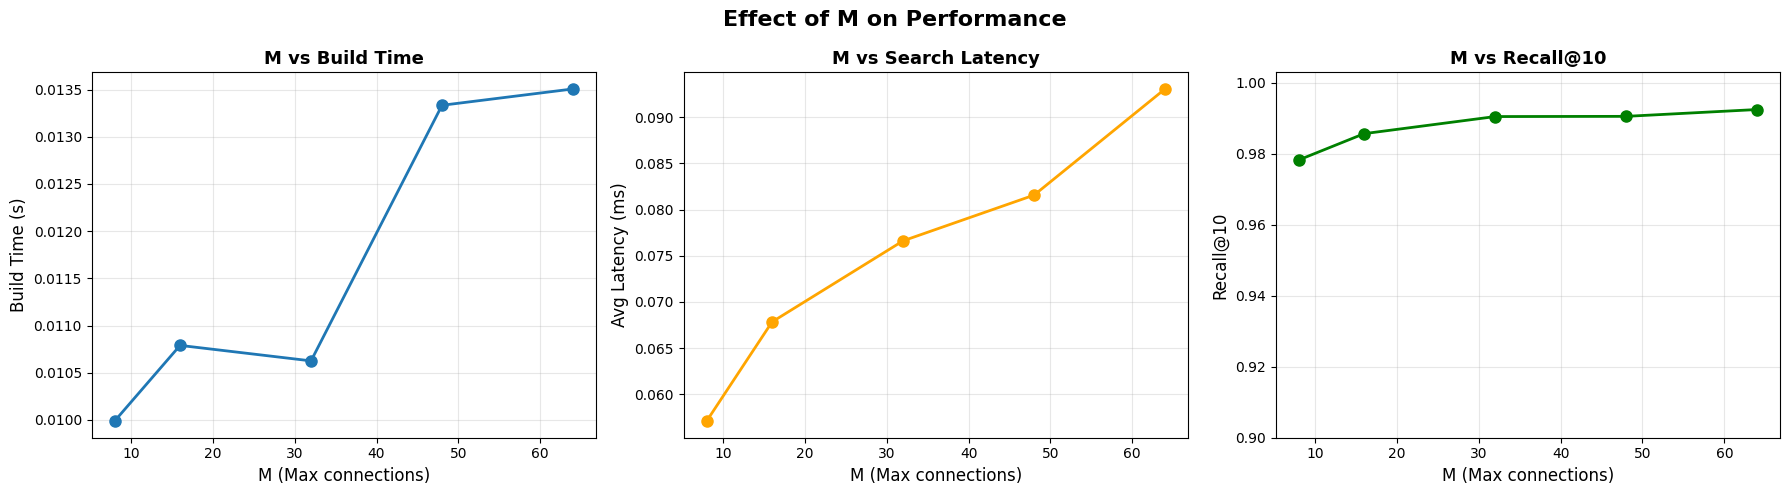

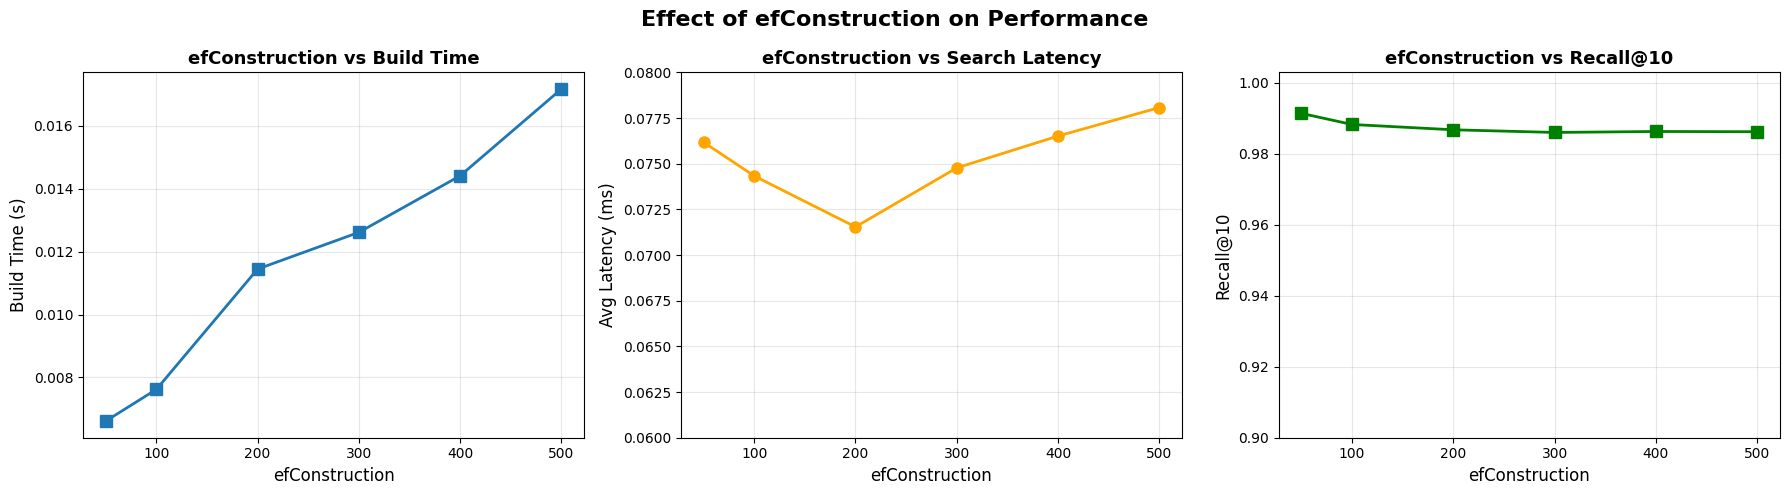

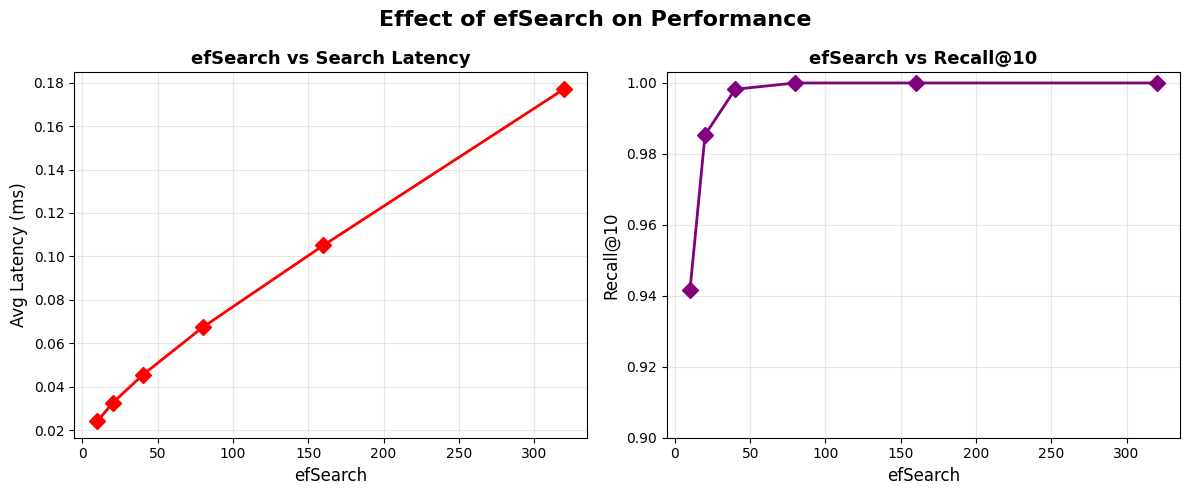

In [126]:
import matplotlib.pyplot as plt

# 시각화 하이퍼파라미터
FIGSIZE_M = (18, 5)
FIGSIZE_EFCONS = (18, 5)
FIGSIZE_EFSEARCH = (12, 5)
RECALL_YMIN, RECALL_YMAX = 0.9, 1.003

# 1) M 별 Figure (Build, Latency, Recall@10)
fig_m, axes_m = plt.subplots(1, 3, figsize=FIGSIZE_M)
fig_m.suptitle('Effect of M on Performance', fontsize=16, fontweight='bold')

# M vs Build Time
m_build_avg = df_results.groupby('M')['build_time'].mean()
axes_m[0].plot(m_build_avg.index, m_build_avg.values, marker='o', linewidth=2, markersize=8)
axes_m[0].set_xlabel('M (Max connections)', fontsize=12)
axes_m[0].set_ylabel('Build Time (s)', fontsize=12)
axes_m[0].set_title('M vs Build Time', fontsize=13, fontweight='bold')
axes_m[0].grid(True, alpha=0.3)

# M vs Latency
m_latency_avg = df_results.groupby('M')['avg_latency_ms'].mean()
axes_m[1].plot(m_latency_avg.index, m_latency_avg.values, marker='o', linewidth=2, markersize=8, color='orange')
axes_m[1].set_xlabel('M (Max connections)', fontsize=12)
axes_m[1].set_ylabel('Avg Latency (ms)', fontsize=12)
axes_m[1].set_title('M vs Search Latency', fontsize=13, fontweight='bold')
axes_m[1].grid(True, alpha=0.3)

# M vs Recall@10
m_recall_avg = df_results.groupby('M')['recall@10'].mean()
axes_m[2].plot(m_recall_avg.index, m_recall_avg.values, marker='o', linewidth=2, markersize=8, color='green')
axes_m[2].set_xlabel('M (Max connections)', fontsize=12)
axes_m[2].set_ylabel('Recall@10', fontsize=12)
axes_m[2].set_title('M vs Recall@10', fontsize=13, fontweight='bold')
axes_m[2].grid(True, alpha=0.3)
axes_m[2].set_ylim(RECALL_YMIN, RECALL_YMAX)

plt.tight_layout()
plt.show()

# 2) efConstruction 별 Figure (Build, Recall@10)
fig_ec, axes_ec = plt.subplots(1, 3, figsize=FIGSIZE_EFCONS)
fig_ec.suptitle('Effect of efConstruction on Performance', fontsize=16, fontweight='bold')

ef_cons_build_avg = df_results.groupby('efConstruction')['build_time'].mean()
axes_ec[0].plot(ef_cons_build_avg.index, ef_cons_build_avg.values, marker='s', linewidth=2, markersize=8)
axes_ec[0].set_xlabel('efConstruction', fontsize=12)
axes_ec[0].set_ylabel('Build Time (s)', fontsize=12)
axes_ec[0].set_title('efConstruction vs Build Time', fontsize=13, fontweight='bold')
axes_ec[0].grid(True, alpha=0.3)

ef_cons_latency_avg = df_results.groupby('efConstruction')['avg_latency_ms'].mean()
axes_ec[1].plot(ef_cons_latency_avg.index, ef_cons_latency_avg.values, marker='o', linewidth=2, markersize=8, color='orange')
axes_ec[1].set_xlabel('efConstruction', fontsize=12)
axes_ec[1].set_ylabel('Avg Latency (ms)', fontsize=12)
axes_ec[1].set_title('efConstruction vs Search Latency', fontsize=13, fontweight='bold')
axes_ec[1].grid(True, alpha=0.3)
axes_ec[1].set_ylim(0.06, 0.08)

ef_cons_recall_avg = df_results.groupby('efConstruction')['recall@10'].mean()
axes_ec[2].plot(ef_cons_recall_avg.index, ef_cons_recall_avg.values, marker='s', linewidth=2, markersize=8, color='green')
axes_ec[2].set_xlabel('efConstruction', fontsize=12)
axes_ec[2].set_ylabel('Recall@10', fontsize=12)
axes_ec[2].set_title('efConstruction vs Recall@10', fontsize=13, fontweight='bold')
axes_ec[2].grid(True, alpha=0.3)
axes_ec[2].set_ylim(RECALL_YMIN, RECALL_YMAX)

plt.tight_layout()
plt.show()

# 3) efSearch 별 Figure (Latency, Recall@10)
fig_es, axes_es = plt.subplots(1, 2, figsize=FIGSIZE_EFSEARCH)
fig_es.suptitle('Effect of efSearch on Performance', fontsize=16, fontweight='bold')

# efSearch vs Latency
ef_search_latency = df_results.groupby('efSearch')['avg_latency_ms'].mean()
axes_es[0].plot(ef_search_latency.index, ef_search_latency.values, marker='D', linewidth=2, markersize=8, color='red')
axes_es[0].set_xlabel('efSearch', fontsize=12)
axes_es[0].set_ylabel('Avg Latency (ms)', fontsize=12)
axes_es[0].set_title('efSearch vs Search Latency', fontsize=13, fontweight='bold')
axes_es[0].grid(True, alpha=0.3)

# efSearch vs Recall@10
ef_search_recall = df_results.groupby('efSearch')['recall@10'].mean()
axes_es[1].plot(ef_search_recall.index, ef_search_recall.values, marker='D', linewidth=2, markersize=8, color='purple')
axes_es[1].set_xlabel('efSearch', fontsize=12)
axes_es[1].set_ylabel('Recall@10', fontsize=12)
axes_es[1].set_title('efSearch vs Recall@10', fontsize=13, fontweight='bold')
axes_es[1].grid(True, alpha=0.3)
axes_es[1].set_ylim(RECALL_YMIN, RECALL_YMAX)

plt.tight_layout()
plt.show()
